In [1]:
import xarray as xr
import geopandas as gpd
import rioxarray
import pandas as pd
from datetime import date
from matplotlib import pyplot as plt
import numpy as np
import pyproj
import pickle
import matplotlib.dates as mdates

In [2]:
# Lazily load all HS netcdf 
ds = xr.open_mfdataset('snd_UERRA_MESCAN_SURFEX_1961_2018_alps/snd_UERRA_MESCAN_SURFEX_day_*.nc')

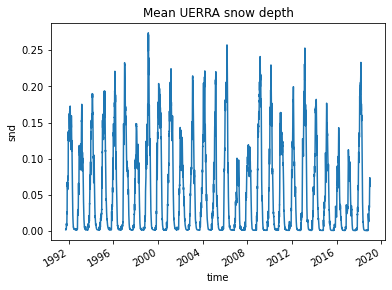

In [3]:
# Select period of interest 
endClimDate = '2021-07-01'
startClimDate = '1991-10-01'
datesSel = ds['time'].sel(time=slice(startClimDate, endClimDate)) # exceeds 1984-2014
# reduce UERRA dataset to these dates
dsSel = ds.sel(time=datesSel)
# plot mean snow depth
dsSel.snd.mean(dim=('x','y')).plot()
plt.title('Mean UERRA snow depth');

In [4]:
# Make X array with predictors
X = dsSel['snd'].values.reshape(datesSel.size,-1)
# remove nodata [TODO: APPLY MODIS AOI MASK]
ix = np.all(np.isnan(X),axis=0)
# This is the array of training data (snow depth of every cell)
X = X[:,~ix]

In [5]:
mod = pickle.load( open( "mod2AlpsScf01July5d.pickle", "rb" ) )

In [6]:
xmod = mod.predict(X)

In [7]:
lastPredDate = datesSel[-1]

In [8]:
f = 'AlpsScf01July'
# create date and scf arrays from Modis csv
dfscf = pd.read_csv('Modis/{}.csv'.format(f), index_col=0, decimal='.')
#dfscf = pd.read_csv('Modis/AlpsScf01July.csv', index_col=0)
doy = dfscf.index
dfdate = pd.DataFrame([pd.to_datetime(doy-1, unit='D', origin=str(y)) for y in dfscf.columns]).transpose()
dfdate.index = dfscf.index
dfdate.columns = dfscf.columns
dates = dfdate.transpose().stack(dropna=False)
scf = dfscf.transpose().stack(dropna=False)

In [9]:
# index of modis dates taht will be used to complete the predicted series
ix = np.logical_and(dates > lastPredDate.values, dates < np.datetime64(endClimDate))

In [10]:
datesClim = pd.concat([
    pd.Series(datesSel), 
    pd.Series(dates[ix])]
    , axis=0, ignore_index=True)

In [11]:
scfClim = pd.concat([
    pd.Series(xmod),
    pd.Series(scf[ix])]
    , axis = 0, ignore_index=True)

In [12]:
def plotYear(year):
    fig = plt.figure(figsize=(12, 5), dpi=100)
    (ax1, ax2) = fig.subplots(ncols=2, sharey=True)

    ax1.plot(datesClim, scfClim)
    ax1.set_ylabel('Snow cover fraction')
    ax1.set_xlabel('Time')

    ax2.plot(datesClim, scfClim)
    ax2.set_xlabel('Time')

    ax1.set_title('{}-{}'.format(year,year+1))
    ax2.set_title('{}-{}'.format(year+1,year+2))
    ax1.set_xlim([date(year,11,1), date(year+1,7,1)])
    ax2.set_xlim([date(year+1,11,1), date(year+2,7,1)])
    ax1.set_ylim([0,1])
    
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))


In [13]:
# convert dates to millis (POSIX) to match 'system:time_start' in earth engine
millis = pd.Series(datesClim, name='system:time_start')
millis = millis.apply(lambda x: x.replace(hour=0).timestamp()*1000 )
# convert dates at 6:00 to date only
#dates = pd.Series(datesSel, name='dates').dt.date

In [14]:
# concat scf
outdf = pd.concat([millis, pd.Series(scfClim, name='scf')], axis = 1)
outdf.set_index('system:time_start',inplace=True)
outdf.to_csv('export/predicteedScf.csv')

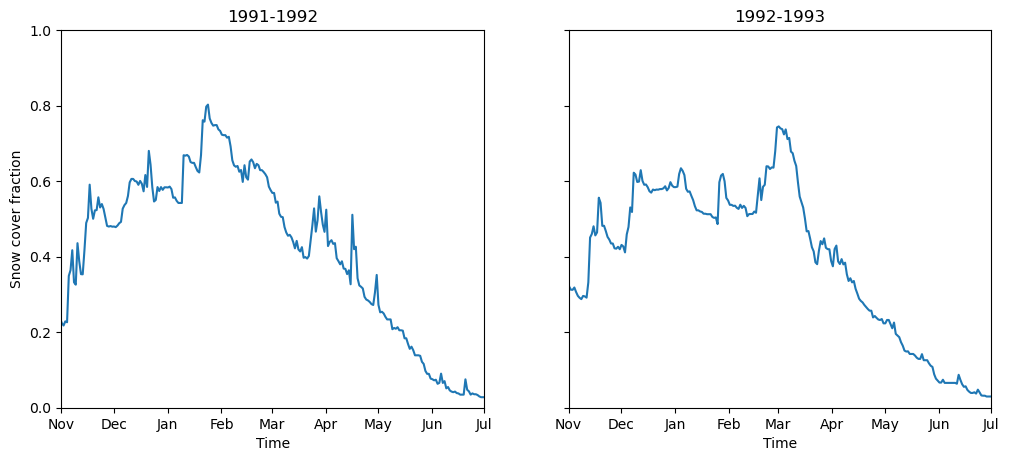

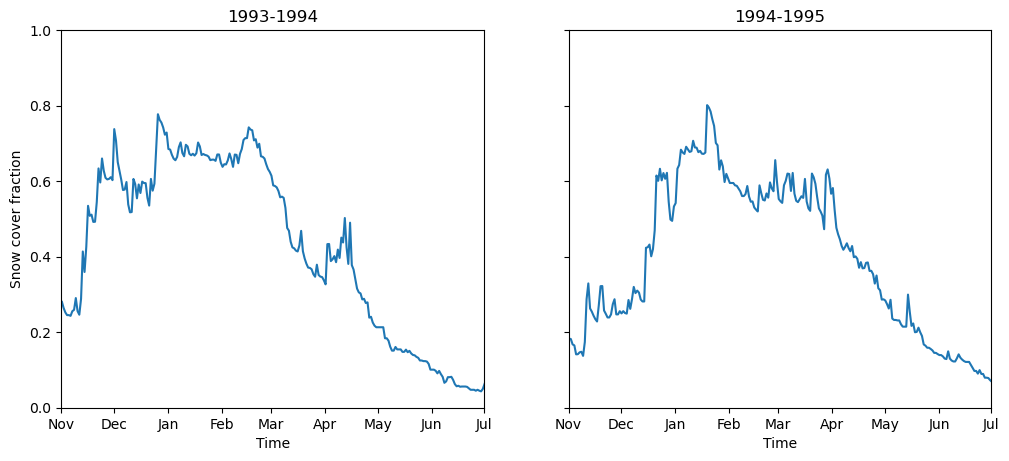

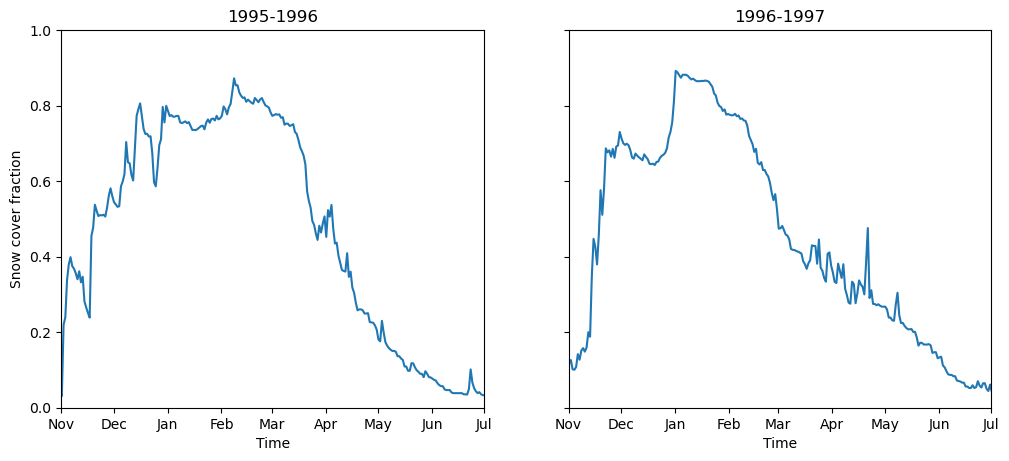

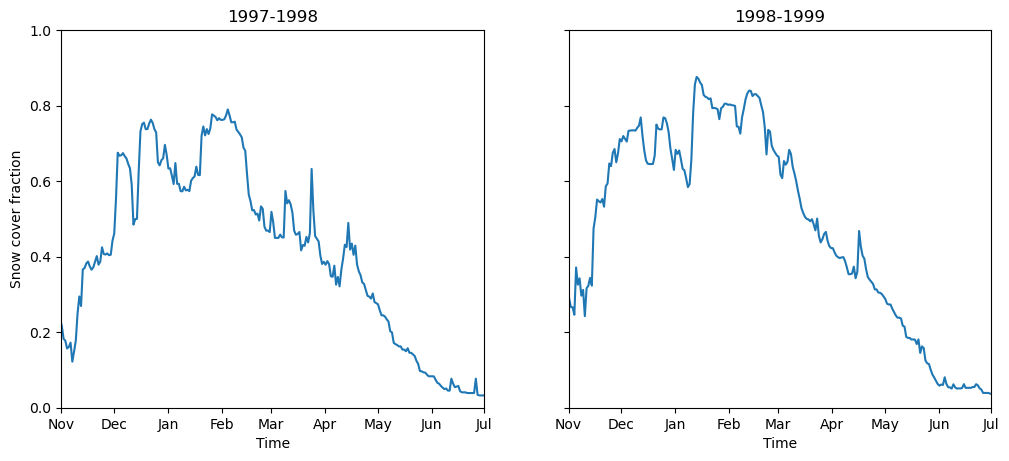

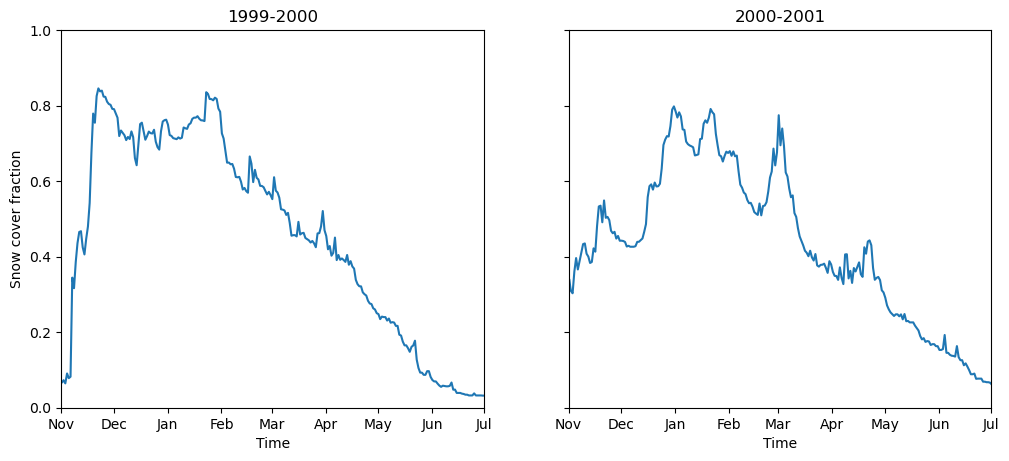

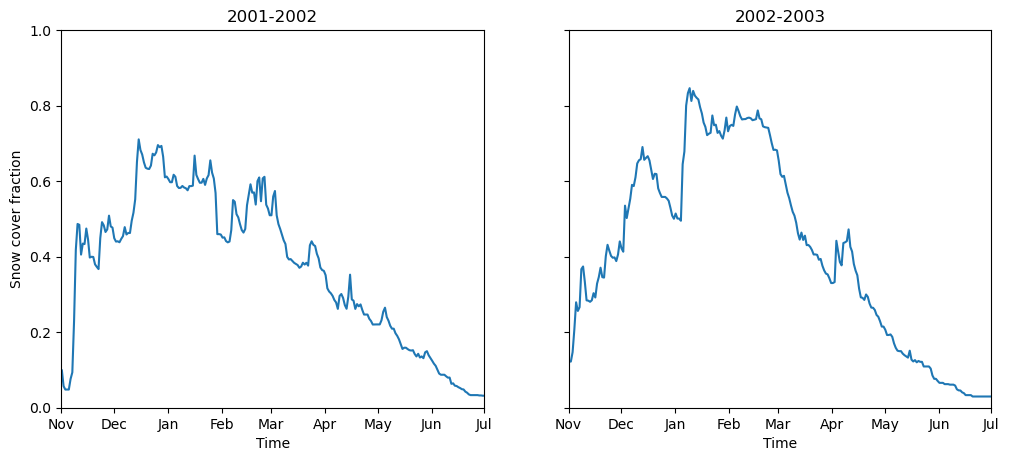

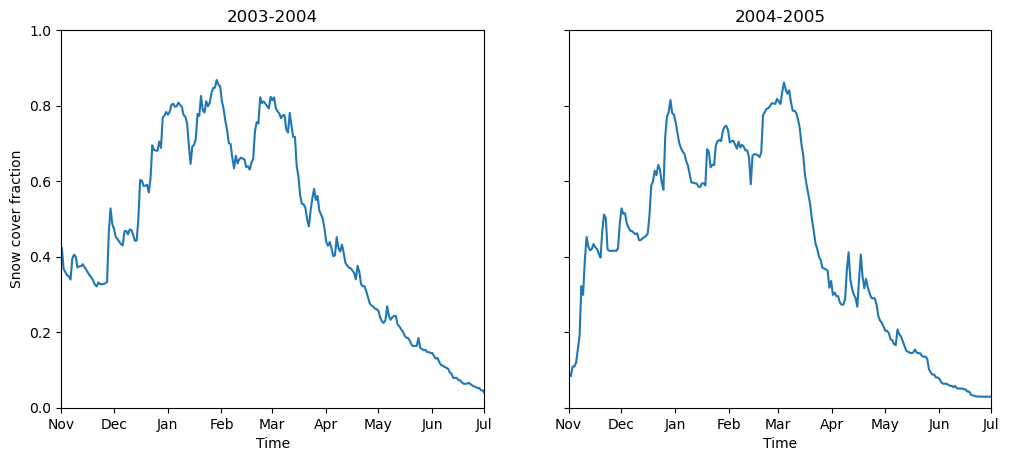

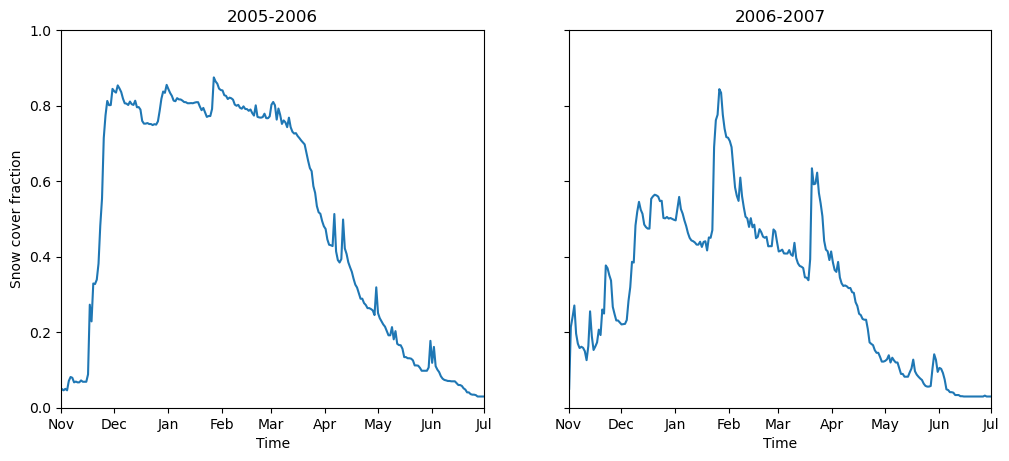

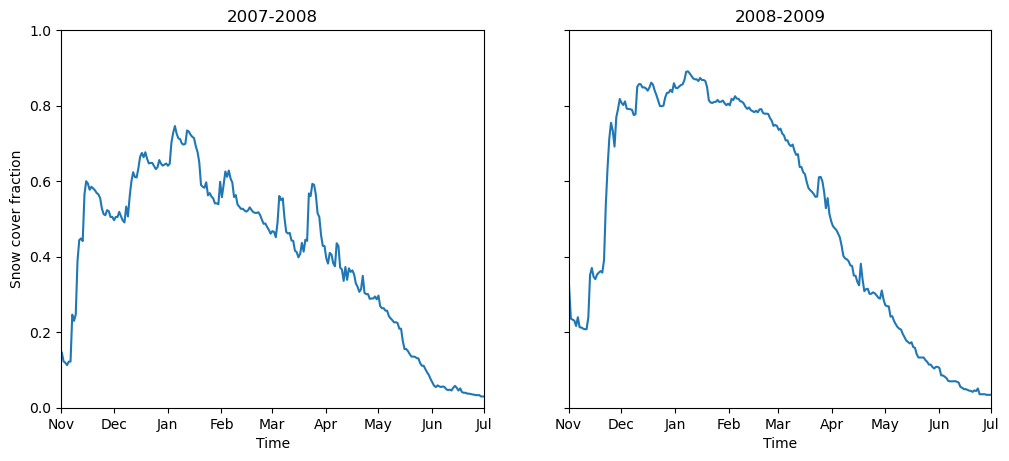

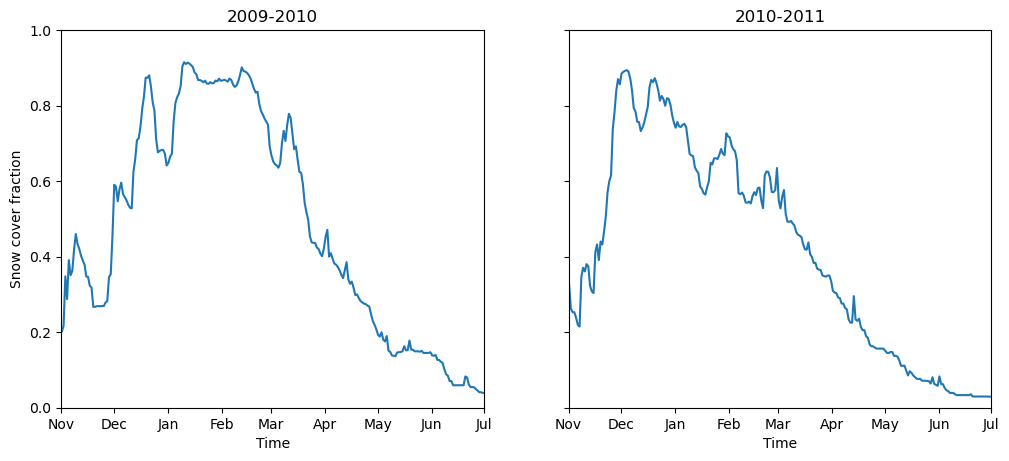

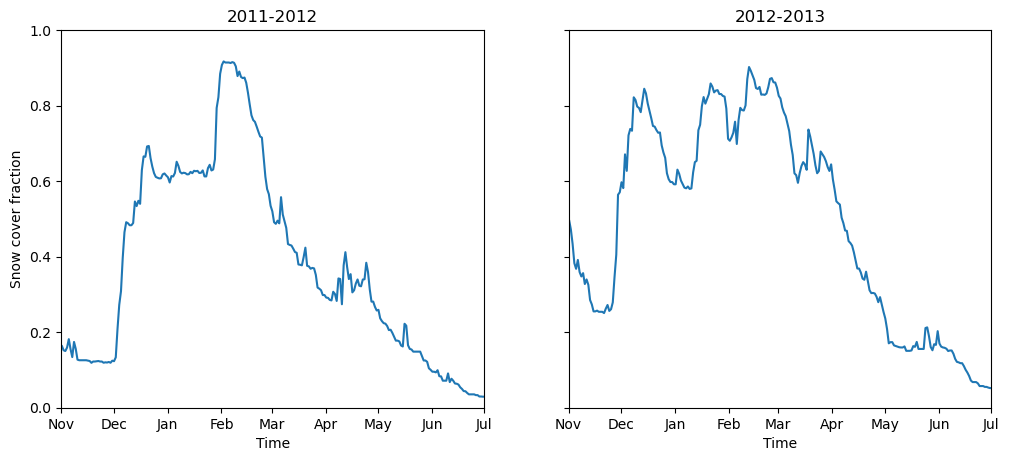

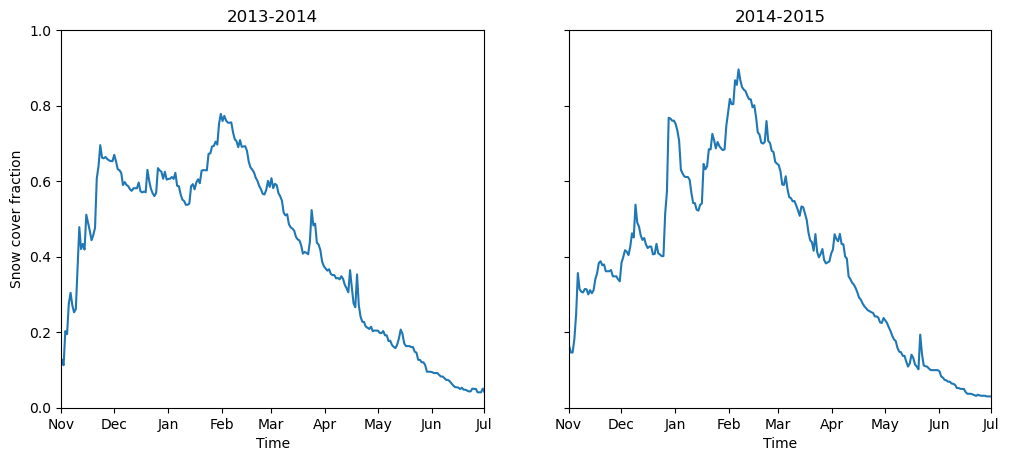

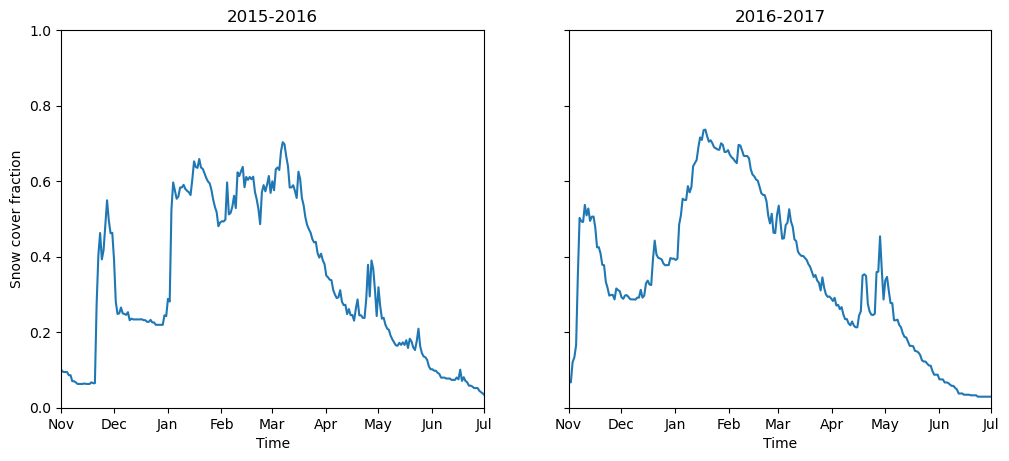

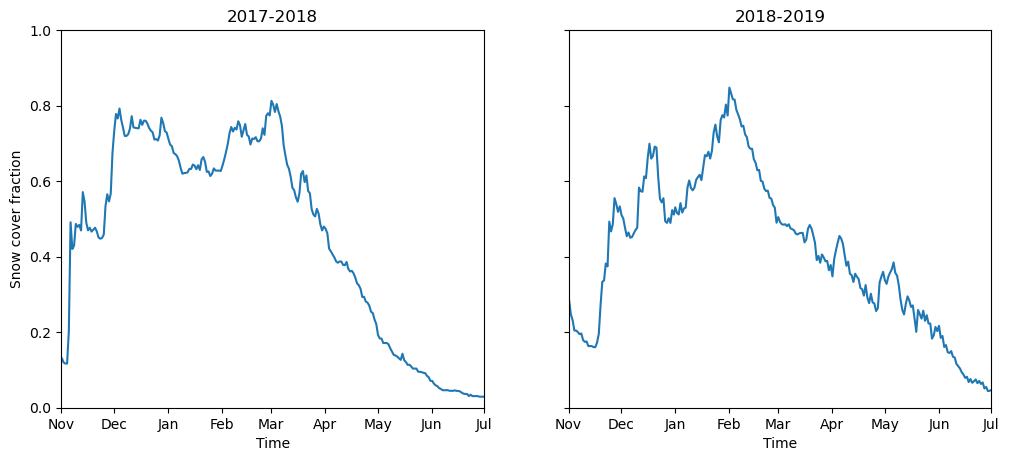

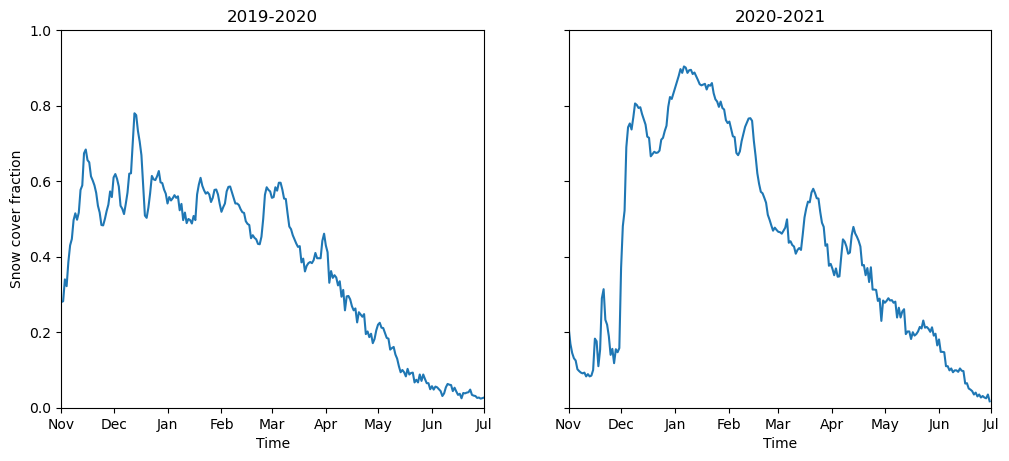

In [15]:
for year in range(1991,2021,2):
    plotYear(year)

In [16]:
years = range(1991,2021)

def reshapeDowy(series):
    tmpList = list()
    for y in years:
        ix = np.logical_and(datesClim >= np.datetime64(date(y,11,1)), datesClim < np.datetime64(date(y+1,7,1))) 
        tmpList.append(series.values[ix])
    df = pd.DataFrame(tmpList).transpose()
    df.columns = years
    return df

scfClimDowy = reshapeDowy(scfClim)
datesClimDowy = reshapeDowy(datesClim)
scfClimDowy.index = datesClimDowy.iloc[0:scfClimDowy.shape[0],0]

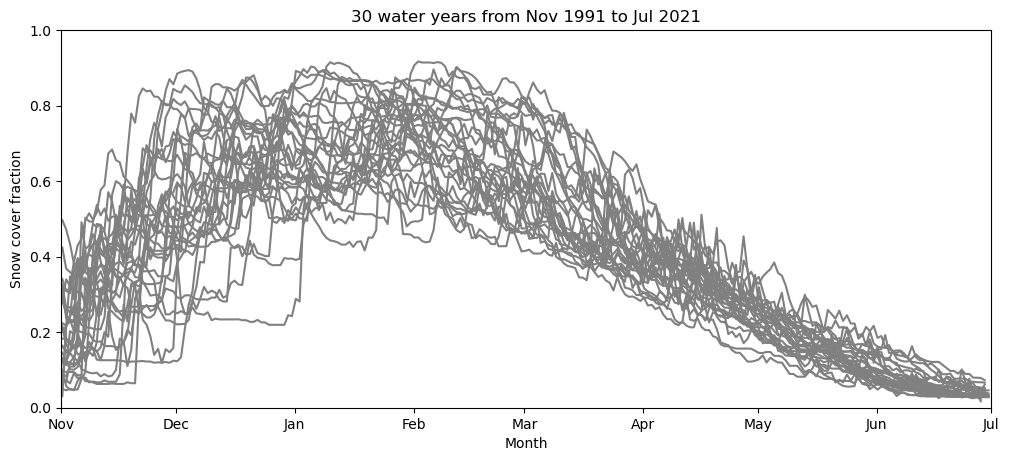

In [17]:
fig = plt.figure(figsize=(12, 5), dpi=100)
ax1 = fig.subplots(ncols=1)

ax1.plot(scfClimDowy, color='grey')
ax1.set_ylabel('Snow cover fraction')
ax1.set_xlabel('Month')
ax1.set_title('{} water years from Nov {} to Jul {}'.format(len(years),years[0],years[-1]+1))
ax1.set_xlim([date(years[0],11,1), date(years[0]+1,7,1)])
ax1.set_ylim([0,1])
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))


In [18]:
# Day of water year (same hydrological year time vector)
#datesClimDowy = [d.replace(year=2003) if d.month > 9 else d.replace(year=2004) for d in datesClim ]